In [12]:
from __future__ import print_function
import torch
from torch.autograd import Variable, Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe, CharNGram

import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pickle import dump

from minimax_entropy import MinimaxEntropyEstimator

# https://github.com/pytorch/text
# http://cogcomp.org/Data/QA/QC/
# note, increasing dim decreases loss (we can see that disimilar things in hd space are very far away)

In [2]:
n_samples = 50
batch_size = 100
learning_rate = 1
dim = 1000
classes = 6
class_dict = {'loc':0, 'hum':1, 'num':2, 'abbr':3, 'enty':4, 'desc':5}
word_dict = {}
alph = 'abcdefghijklmnopqrstuvwxyz#.:-'
letter_vecs = 2 * (np.random.randn(len(alph), dim) < 0) - 1

entro = MinimaxEntropyEstimator('poly_coeff_entro.mat', n_samples, gpu=True)

In [3]:
def read_data(url):
    texts, labels = [], []
    with open(url) as f:
        content = f.readlines()
        content = list(set(content))
        for i in range(len(content)):
            l = content[i].lower()
            l = l.replace('\'', '')
            l = l.replace('``', '')
            l = l.replace('?', '')
            l = l.split(' ')
            l = filter(None, l)
            
            label = l[0].split(':')[0]
            l = l[1:len(l)-1]
            texts.append(l)
            labels.append(class_dict[label])
    return texts, labels

def batch_data(texts, labels, batch_size):
    text_batches, label_batches = [], []
    previ = 0
    for i in range(batch_size,len(texts), batch_size):
        text_batches.append(texts[previ:i])
        label_batches.append(np.array(labels[previ:i]))
        previ = i
    remainder = len(texts)% batch_size

    if len(texts) % batch_size != 0:
        ri = len(texts)-remainder
        text_batches.append(texts[ri:])
        label_batches.append(np.array(labels[ri:]))
    return text_batches, label_batches

def ngram_encode(ngram_str):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str):
    vec = ngram_encode(ngram_str)
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def encode_text(texts):
    sentences = np.zeros((len(texts), dim))
    for i in range(len(texts)):
        s_vec = np.ones(dim)
        for j in range(len(texts[i])):
            vec = ngram_encode_cl(texts[i][j])
            s_vec = s_vec*np.roll(vec, j)
        sentences[i] = s_vec
    return sentences


In [4]:
testurl = 'data/raw/TREC_10.label'
trainurl = 'data/raw/train_5500.label'
test_texts, test_labels = read_data(testurl)
train_texts, train_labels = read_data(trainurl)

In [5]:
train_batches, y_batches = batch_data(train_texts, train_labels, batch_size)
train_vecs = [encode_text(text) for text in train_batches]

# test_vecs = encode_text(test_texts)
# train_vecs = encode_text(train_texts)

test_batches, ytest_batches = batch_data(test_texts, test_labels, batch_size)
test_vecs = [encode_text(text) for text in test_batches]

In [16]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = batch_size, dim, 100, 6

batch_idx = 0
p_drop = 0.1 # 0.05
learning_rate = 1e-4
losses = []
accuracies = []

#loss_fn = entro.cross_entro_loss
loss_fn = entro.minimax_cross_entro

stats_fn = 'results/text_mm_ce_evals.pkl'

In [17]:
def accuracy(yhat, labels):
    maxs, indices = torch.max(torch.exp(yhat), 1)
    indices = indices.data.cpu().numpy()
    correct = 0
    for i in range(labels.shape[0]):
        
        if indices[i] == labels[i]:
            correct += 1
    return correct/float(labels.shape[0])

model = torch.nn.Sequential(
          torch.nn.Linear(D_in, 500),
          torch.nn.ReLU(),
          torch.nn.Dropout(p=p_drop),
          torch.nn.Linear(500, 100),
          torch.nn.ReLU(),
          torch.nn.Dropout(p=p_drop),
          torch.nn.Linear(100, D_out),
          torch.nn.Softmax()
        )
model = model.cuda()
opt = optim.Adam(model.parameters())

evals = {
    'tr_loss': [],
    't_loss': [],
    'tr_accu': [],
    't_accu': [],
    'ts': []
}

for t in range(30):
    model.train()
    
    x = Variable(torch.FloatTensor(train_vecs[t % 4]).cuda(), requires_grad=True)
    batch_size = y_batches[t % 4].shape[0]
    
    yhot = np.zeros((batch_size, D_out))
    yhot[[idx for idx in range(yhot.shape[0])], y_batches[batch_idx]] = 1
    y = Variable(torch.DoubleTensor(yhot).cuda(), requires_grad=False)
    
    y_pred = Variable(torch.zeros(batch_size, classes)).cuda().double()
    y_preds = [model(x).double() for _ in range(n_samples)]
    for y_pred_i in y_preds:
        y_pred = y_pred + y_pred_i
    y_pred /= n_samples

    loss = Variable(torch.zeros(1).cuda(), requires_grad=True).double()
    for i in range(batch_size):
        loss += loss_fn(y_pred[i], y[i])
    loss.backward()
    opt.step()
    
    model.eval()

    tr_accu = accuracy(y_pred, np.array(y_batches[batch_idx]))
    tr_loss = loss.data[0] / batch_size
    
    test_losses, test_accus = [], []
    for i, test_vec in enumerate(test_vecs):
        test_label = ytest_batches[i]
        x_vec = Variable(torch.FloatTensor(test_vec).cuda(), requires_grad=True)
        test_pred = model(x_vec).double()
        
        yhot = np.zeros((y_batches[0].shape[0], D_out))
        yhot[[i for i in range(yhot.shape[0])], test_label] = 1
        y = Variable(torch.DoubleTensor(yhot).cuda(), requires_grad=False)
        
        test_loss_i = Variable(torch.zeros(1).cuda(), requires_grad=True).double()
        for j in range(len(test_vec)):            
            test_loss_i += loss_fn(test_pred[j], y[j])
            
        test_losses.append(test_loss_i.data[0] / len(test_vec))
        
        test_accus.append(accuracy(test_pred, test_label))       

    t_accu = np.mean(test_accus)
    t_loss = np.mean(test_losses)
    print ('batch {} | train loss {:.3f} acc {:.3f} | test loss {:.3f} acc {:.3f}'.format(t, tr_loss, tr_accu,
                                                                                          t_loss, t_accu))
    evals['tr_loss'].append(tr_loss)
    evals['t_loss'].append(t_loss)
    evals['tr_accu'].append(tr_accu)
    evals['t_accu'].append(t_accu)
    evals['ts'].append(t)

batch 0 | train loss 1.837 acc 0.170 | test loss 1.785 acc 0.250
batch 1 | train loss 1.801 acc 0.150 | test loss 1.761 acc 0.230
batch 2 | train loss 1.767 acc 0.190 | test loss 1.744 acc 0.230
batch 3 | train loss 1.756 acc 0.210 | test loss 1.733 acc 0.220
batch 4 | train loss 1.248 acc 0.980 | test loss 1.729 acc 0.227
batch 5 | train loss 1.381 acc 0.780 | test loss 1.729 acc 0.228
batch 6 | train loss 1.409 acc 0.660 | test loss 1.733 acc 0.233
batch 7 | train loss 1.480 acc 0.480 | test loss 1.740 acc 0.235
batch 8 | train loss 0.894 acc 0.980 | test loss 1.750 acc 0.225
batch 9 | train loss 0.965 acc 0.900 | test loss 1.761 acc 0.217
batch 10 | train loss 0.962 acc 0.890 | test loss 1.775 acc 0.208
batch 11 | train loss 1.046 acc 0.760 | test loss 1.792 acc 0.203
batch 12 | train loss 0.457 acc 0.980 | test loss 1.816 acc 0.210
batch 13 | train loss 0.487 acc 0.970 | test loss 1.855 acc 0.217
batch 14 | train loss 0.462 acc 0.970 | test loss 1.915 acc 0.215
batch 15 | train los

In [18]:
with open(stats_fn, 'w') as f:
    dump(evals, f)

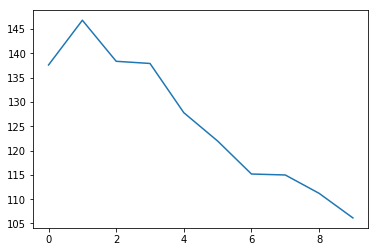

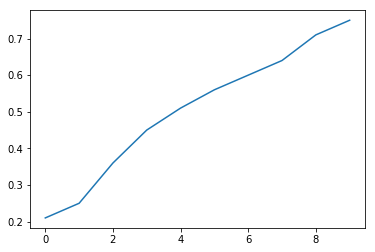

In [164]:
plt.figure()
plt.plot(losses)
plt.show()

plt.figure()
plt.plot(accuracies)
plt.show()